# SETUP MÔI TRƯỜNG

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import seaborn as sns
from pyvi import ViTokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


# LOAD DATASET

In [2]:
df = pd.read_csv('/Users/voquangkhai/Desktop/NLP Sentiment Analysis/Dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53451 entries, 0 to 53450
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             53451 non-null  object
 1   publishedAtDate   53451 non-null  object
 2   originalLanguage  26707 non-null  object
 3   textTranslated    5386 non-null   object
 4   text              26627 non-null  object
 5   stars             53451 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.4+ MB


In [4]:
df.shape

(53451, 6)

In [5]:
df.head()

,title,publishedAtDate,originalLanguage,textTranslated,text,stars
0,Siêu thị Co.opmart Nha Trang,2025-06-14T08:20:44.449Z,vi,NaN,"Khu vui chơi nóng mặc dù rất ít trẻ nhỏ chơi, ...",1
1,Siêu thị Co.opmart Nha Trang,2025-09-05T01:15:13.880Z,vi,NaN,cái quầy giữ đồ của khách làm ăn khó chịu thật...,1
2,Siêu thị Co.opmart Nha Trang,2025-10-18T02:34:51.862Z,vi,NaN,Mua hàng online. Mặt hàng để còn hàng nhưng lú...,1
3,Siêu thị Co.opmart Nha Trang,2025-06-21T12:36:28.800Z,vi,NaN,"Bán hàng thì đắt hon các siêu thị khác, giữ xe...",1
4,Siêu thị Co.opmart Nha Trang,2025-07-07T12:21:30.734Z,vi,NaN,- Siêu thị duy nhất thu tiền giữ xe\n- Nhân vi...,1


In [6]:
df.tail()

,title,publishedAtDate,originalLanguage,textTranslated,text,stars
53446,Co.opmart Thủ Dầu Một,2025-05-21T13:55:15.546Z,NaN,NaN,NaN,5
53447,Co.opmart Thủ Dầu Một,2025-05-20T10:54:18.780Z,NaN,NaN,NaN,5
53448,Co.opmart Thủ Dầu Một,2025-05-14T13:11:58.722Z,NaN,NaN,NaN,5
53449,Co.opmart Thủ Dầu Một,2025-05-11T02:18:15.470Z,NaN,NaN,NaN,5
53450,Co.opmart Thủ Dầu Một,2025-05-08T07:48:29.705Z,NaN,NaN,NaN,5


## CHUẨN HÓA TẠO CỘT COMMENT

In [7]:
df['comment'] = (df['text'].where(df['originalLanguage'] == 'vi', df['textTranslated']))

In [8]:
df['comment'] = (df['comment'].astype(str))

# CHUẨN HÓA DỮ LIỆU COMMENT

In [9]:
ACRONYMS = {
    "r": "rồi", "a": "anh", "e": "em", "j": "gì", "k": "không", "m": "mình",
    "t": "tôi", "b": "bạn", "h": "giờ", "s": "sao",

    "ko": "không", "k0": "không", "bt": "bình thường", "vn": "việt nam", "vs": "và",
    "cx": "cũng được", "đc": "được", "dc": "được", "nh": "nhưng", "đg": "đường",
    "nc": "nước", "ms": "mới", "bh": "bao giờ", "km": "khuyến mãi", "ae": "anh em",
    "sg": "sài gòn", "hn": "hà nội", "vk": "vợ", "ck": "chồng", "nv": "nhân viên",
    "mn": "mọi người", "qc": "quảng cáo", "sp": "sản phẩm", "sd": "sử dụng", "wa": "quá",

    "ntn": "như thế nào", "lun": "luôn", "trc": "trước", "chx": "chưa", "nhg": "nhưng",
    "spt": "sản phẩm tốt", "nch": "nói chung", "kbh": "không bao giờ",

    "tnao": "thế nào", "hqua": "hôm qua", "toẹt": "tuyệt", "nhưg": "nhưng",
    "hnay": "hôm nay", "thik": "thích",

    "lquan": "liên quan", "nchung": "nói chung", "k_thể": "không thể"
}

def replace_acronyms(text):
    for abbr, full in ACRONYMS.items():
        text = re.sub(rf'\b{abbr}\b', full, text)
    return text

def remove_emoji(text):
    emoji_pattern = re.compile(
        "[" +
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "\U00002700-\U000027BF"
        "\U0001F900-\U0001F9FF"
        "\U0001FA70-\U0001FAFF"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub('', text)

def remove_special_characters(text):
    text = re.sub(r"http\S+|www\S+|@\S+|#\S+", " ", text)
    text = re.sub(r"[^a-zA-ZÀ-ỹà-ỹ\s]", " ", text)
    return text

def normalize_vietnamese(text):
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ',
        'òe': 'oè', 'óe': 'oé', 'ỏe': 'oẻ', 'õe': 'oẽ', 'ọe': 'oẹ',
        'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ', 'ụy': 'uỵ',
        'uả': 'ủa', 'ả': 'ả', 'ố': 'ố', 'u´': 'ố', 'ỗ': 'ỗ', 'ồ': 'ồ',
        'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ', 'ầ': 'ầ', 'ỏ': 'ỏ',
        'ề': 'ề', 'ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở',
        'ỉ': 'ỉ', 'ẻ': 'ẻ', 'àk': ' à ', 'aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ',
        'ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á'
    }
    for k, v in replace_list.items():
        text = text.replace(k, v)
    text = re.sub(r'([a-zA-Zà-ỹ])\1{2,}', r'\1', text)
    return text

def preprocess_text(text):
    if text is None or (isinstance(text, float) and pd.isna(text)):
        return ""

    text = text.lower()
    text = text.replace("\n", " ").replace("\r", " ").replace("\t", " ")
    text = remove_emoji(text)
    text = normalize_vietnamese(text)
    text = remove_special_characters(text)
    text = replace_acronyms(text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ViTokenizer.tokenize(text)
    return text


In [10]:
df['comment'] = df['comment'].apply(preprocess_text)


In [11]:
df['comment'] = df['comment'].fillna('').astype(str)
df['comment'] = df['comment'].apply(preprocess_text)
df['comment'] = df['comment'].replace('nan', '')
df = df[df['comment'].str.strip() != '']
df = df[df['comment'].str.split().str.len() >= 3]
df

,title,publishedAtDate,originalLanguage,textTranslated,text,stars,comment
0,Siêu thị Co.opmart Nha Trang,2025-06-14T08:20:44.449Z,vi,NaN,"Khu vui chơi nóng mặc dù rất ít trẻ nhỏ chơi, ...",1,khu vui_chơi nóng mặc_dù rất ít trẻ nhỏ chơi c...
1,Siêu thị Co.opmart Nha Trang,2025-09-05T01:15:13.880Z,vi,NaN,cái quầy giữ đồ của khách làm ăn khó chịu thật...,1,cái quầy giữ đồ của khách làm_ăn khó_chịu thật...
2,Siêu thị Co.opmart Nha Trang,2025-10-18T02:34:51.862Z,vi,NaN,Mua hàng online. Mặt hàng để còn hàng nhưng lú...,1,mua hàng online mặt_hàng để còn hàng nhưng lúc...
3,Siêu thị Co.opmart Nha Trang,2025-06-21T12:36:28.800Z,vi,NaN,"Bán hàng thì đắt hon các siêu thị khác, giữ xe...",1,bán hàng thì đắt hon các siêu_thị khác giữ xe ...
4,Siêu thị Co.opmart Nha Trang,2025-07-07T12:21:30.734Z,vi,NaN,- Siêu thị duy nhất thu tiền giữ xe\n- Nhân vi...,1,siêu_thị duy_nhất thu tiền giữ xe nhân_viên câ...
...,...,...,...,...,...,...,...
53370,Co.opmart Thủ Dầu Một,2018-10-02T08:54:16.001Z,en,chợ thực phẩm sạch,clean grocery market,5,chợ thực_phẩm sạch
53372,Co.opmart Thủ Dầu Một,2017-12-30T09:21:02.347Z,en,Siêu thị hàng ngày của tôi,My everyday supermarket,5,siêu_thị hàng ngày của tôi
53373,Co.opmart Thủ Dầu Một,2016-09-26T15:04:17.051Z,en,Co.opmart rất tốt!!!,Co.opmart very good!!!,5,co opmart rất tốt
53426,Co.opmart Bà Rịa,2019-08-25T08:48:59.797Z,en,Thích hợp cho việc mua sắm,Good for shopping,5,thích_hợp cho việc mua_sắm


# GẮN NHÃN DỮ LIỆU

In [12]:
df2 = df[['comment',"stars"]]
df2

,comment,stars
0,khu vui_chơi nóng mặc_dù rất ít trẻ nhỏ chơi c...,1
1,cái quầy giữ đồ của khách làm_ăn khó_chịu thật...,1
2,mua hàng online mặt_hàng để còn hàng nhưng lúc...,1
3,bán hàng thì đắt hon các siêu_thị khác giữ xe ...,1
4,siêu_thị duy_nhất thu tiền giữ xe nhân_viên câ...,1
...,...,...
53370,chợ thực_phẩm sạch,5
53372,siêu_thị hàng ngày của tôi,5
53373,co opmart rất tốt,5
53426,thích_hợp cho việc mua_sắm,5


In [ ]:
checkpoint = "5CD-AI/Vietnamese-Sentiment-visobert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

def get_sentiments_in_batches(texts, batch_size=128):
    sentiment_mapping = {"POS": "Tích cực", "NEU": "Trung tính", "NEG": "Tiêu cực"}
    model.eval()
    all_sentiments = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)

            for pred in predictions:
                label = model.config.id2label[pred.item()]
                sentiment = sentiment_mapping.get(label, "Không xác định")
                all_sentiments.append(sentiment)

    return all_sentiments




In [11]:
df2['sentiment'] = get_sentiments_in_batches(df2['comment'].tolist(), batch_size=128)

100%|██████████| 169/169 [17:44<00:00,  6.30s/it]
/var/folders/ks/d48p0t5x0dbbt3pngtm7f50r0000gn/T/ipykernel_1810/1027846204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sentiment'] = get_sentiments_in_batches(df2['comment'].tolist(), batch_size=128)


In [12]:
df2

,comment,stars,sentiment
0,khu vui chơi nóng mặc dù rất ít trẻ nhỏ chơi c...,1,Tiêu cực
1,cái quầy giữ đồ của khách làm ăn khó chịu thật...,1,Tiêu cực
2,mua hàng online mặt hàng để còn hàng nhưng lúc...,1,Tiêu cực
3,bán hàng thì đắt hon các siêu thị khác giữ xe ...,1,Tiêu cực
4,siêu thị duy nhất thu tiền giữ xe nhân viên câ...,1,Tiêu cực
...,...,...,...
54985,dịch vụ tốt,5,Tích cực
55027,dịch vụ tốt,5,Tích cực
55032,siêu tuyệt vời,5,Tích cực
55033,thích hợp cho việc mua sắm,5,Tích cực


/var/folders/ks/d48p0t5x0dbbt3pngtm7f50r0000gn/T/ipykernel_1810/344306660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, "length"] = df2["comment"].str.len()


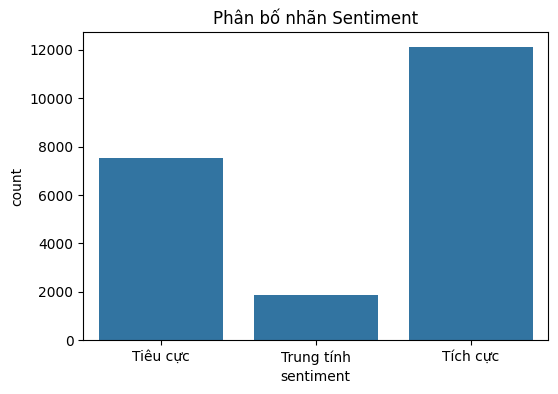

sentiment
Tiêu cực      139.324357
Trung tính     43.559322
Tích cực       64.181811
Name: length, dtype: float64

In [13]:
df2.loc[:, "length"] = df2["comment"].str.len()

plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=df2)
plt.title("Phân bố nhãn Sentiment")
plt.show()

df2.groupby("sentiment")["length"].mean()

# VECTOR HÓA

In [14]:
vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,2))

X = vectorizer.fit_transform(df2["comment"])
y = df2["sentiment"]

# MACHINE LEARNING

## CHIA TỆP DỮ LIỆU

In [1]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

NameError: name 'train_test_split' is not defined

## HUẤN LUYỆN MÔ HÌNH HỌC MÁY

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [ ]:
svm = LinearSVC()
svm.fit(X_train, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [ ]:
models = {
    "Logistic Regression": lr,
    "Naive Bayes": nb,
    "SVM": svm
}

for name, model_ in models.items():
    print(f"\n{name}")
    y_pred = model_.predict(X_test)
    print(classification_report(y_test, y_pred))


Logistic Regression
              precision    recall  f1-score   support

    Tiêu cực       0.86      0.86      0.86      1508
  Trung tính       0.68      0.25      0.36       378
    Tích cực       0.86      0.94      0.90      2423

    accuracy                           0.86      4309
   macro avg       0.80      0.69      0.71      4309
weighted avg       0.85      0.86      0.84      4309


Naive Bayes
              precision    recall  f1-score   support

    Tiêu cực       0.83      0.80      0.81      1508
  Trung tính       0.53      0.06      0.11       378
    Tích cực       0.81      0.93      0.87      2423

    accuracy                           0.81      4309
   macro avg       0.72      0.60      0.60      4309
weighted avg       0.79      0.81      0.78      4309


SVM
              precision    recall  f1-score   support

    Tiêu cực       0.86      0.86      0.86      1508
  Trung tính       0.65      0.36      0.46       378
    Tích cực       0.87      0.93   

# DEEP LEARNING

## CHIA TỆP DỮ LIỆU

In [20]:
X_dense = X.toarray()

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_dense, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [ ]:
model_dl = Sequential([Dense(256, activation="relu", input_shape=(X_train_d.shape[1],)),Dropout(0.3),Dense(128, activation="relu"),Dense(len(le.classes_), activation="softmax")])

model_dl.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

model_dl.summary()

In [ ]:
model_dl.fit(X_train_d,y_train_d,epochs=10,batch_size=32,validation_split=0.1)

In [ ]:
y_pred_dl = model_dl.predict(X_test_d)
y_pred_dl = np.argmax(y_pred_dl, axis=1)

print(classification_report(y_test_d, y_pred_dl, target_names=le.classes_))

In [ ]:
def predict_sentiment_app(text):
    text = preprocess_text(text)
    vec = vectorizer.transform([text])
    return svm.predict(vec)[0]

predict_sentiment_app("Sản phẩm rất tốt, giao hàng nhanh")
